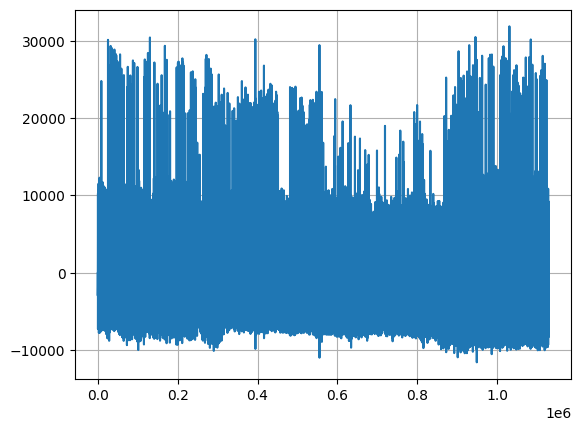

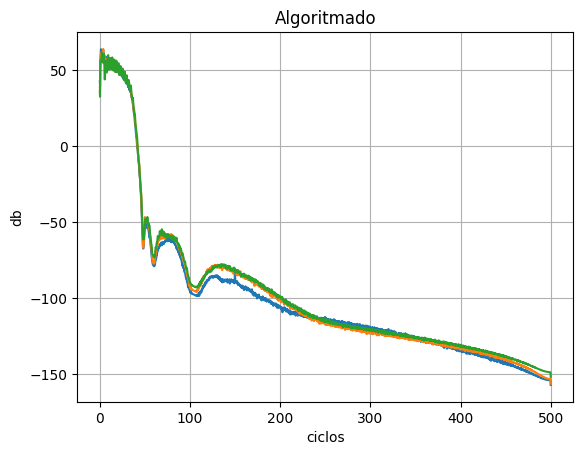

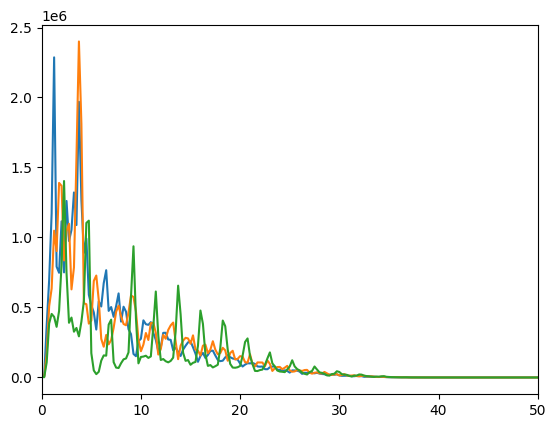

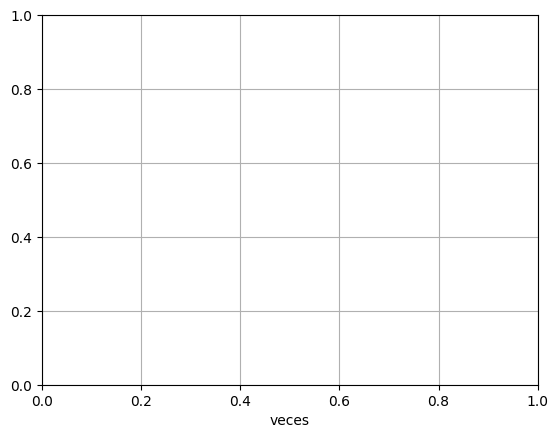

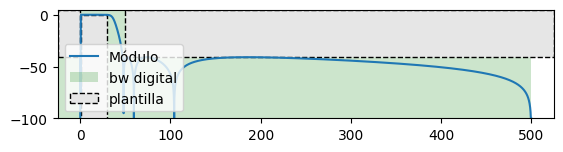

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


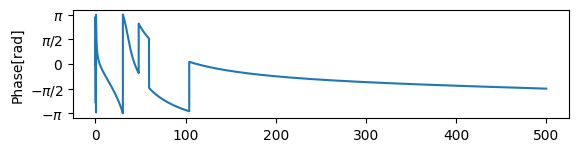

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


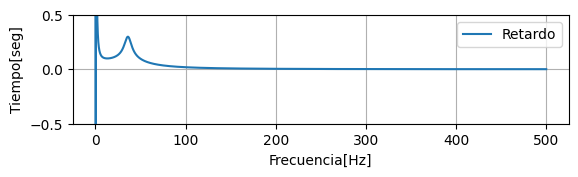

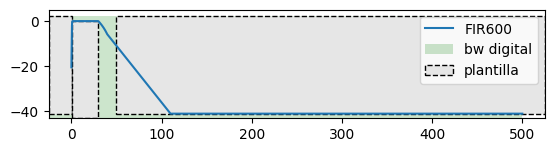

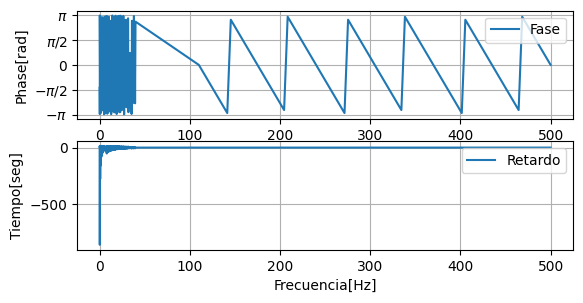

In [6]:
# -*- coding: utf-8 -*-
"""
Created on Fri Nov 25 19:58:11 2022



@author: Guillermo Daniel Spagnolo
         daniespagnolo@frba.utn.edu.ar
"""

#Módulos importantes
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal as sig
from splane import plot_plantilla
from scipy import signal
import scipy.io as sio 

# Módulos para Jupyter
# import warnings
# warnings.filterwarnings('ignore')
#%%
def group_delay( ww , phase):
    groupDelay = -np.diff(phase)/np.diff(ww)#derivada de la Rta de fase cambiada de signo sobre la derivada de la frecuencia
    return(np.append(groupDelay, groupDelay[-1]))#igualo el largo del vector


#%%  CONSTANTES
# N = 1000
fs= 1000          # 1KHz frecuencia de sampling
nyq_frec = fs / 2 # frecuencia de nyquist#
atenuacion = 40   # dB
Proporcion = 0.99 #porcentaje de energia 

#resolution
block = (100,300,760,1000,4000)# definimos como tupla

#%% Carga de Archivo de ECG
mat_struct = sio.loadmat('ECG_TP4.mat')#cargamos el arhivo en mat_struct
ecg_one_lead = mat_struct['ecg_lead']#elegimos la estructura de ecg_lead del archivo
ecg_one_lead = ecg_one_lead.flatten()
cant_muestras = len(ecg_one_lead)

#%%Ploteo de la señal ECG
# plt.figure(1)
# plt.plot(ecg_one_lead,label='ECG')
# plt.xlabel('Muestras')
# plt.grid()
# plt.xlim([0, 100000])

 
#%%     Analisis de la ECG en distintos momentos
######################################
#     Reposo
ECG_reposo = ecg_one_lead[0:100000] #reposo

#  sig.welch(ECG_reposo=valores de medición
# , fs=1.0, window='hann', nperseg=None, noverlap=None, nfft=None, detrend='constant', return_onesided=True, scaling='density', axis=- 1, average='mean')
[f, PXX_pot_reposo] = sig.welch(ECG_reposo, fs=fs, nperseg = block[4],axis=0)

EnergicaAcumulada= np.cumsum(PXX_pot_reposo)
#95 %de la energia 
#where genera una vector con la condicion
IndexEnergia= np.where(np.cumsum(PXX_pot_reposo)/EnergicaAcumulada[-1]>Proporcion)[0]# 99 % 

W_corte0 = f[IndexEnergia[0]]#29 ciclos#95% energia en 29Hz
#%%
# c) Diseñe al menos dos filtros FIR y dos IIR para su comparación. 
# Verifique que la respuesta en frecuencia responda a la plantilla de diseño


#%%bandas y ganancia de los latidos

# filter design
ripple = 0.1  # dB
# ripple = 0.05  # dB Mitad
alfa_max = 41 #dB 
# alfa_max = 20  #dB Atenuacion Mitad
wN=int(5*10e3)#50000

####Hz
# fs0=1.0#Hz
# fc0=3.0#Hz
# fc1=15 #Hz
# fs1=35 #Hz
# frecs = np.array([0.0, fs0,fc0,fc1,fs1,nyq_frec])/nyq_frec
##Frec criticas
ws1 = 0.25 #Hz#STOP
wp1 = 0.75 #Hz#PASO
wp2 = 30.0 #Hz#2DApASO
ws2 = 50.0 #Hz#ATENUACION

frecs = np.array([0.0,         ws1,         wp1,     wp2,     ws2,         nyq_frec   ]) / nyq_frec
gains = np.array([-alfa_max,-alfa_max,-ripple,-ripple,-alfa_max,-alfa_max])
gains = 10**(gains/20)

# len_zeros=3000 #valor de truncamiento de la Rta
len_zeros=int (10e3)

#%%
# scipy.signal.iirdesign(wp, ws, gpass, gstop, analog=False, ftype='ellip', output='ba', fs=None)[source]
#devuelve matriz de sos 
# bp_sos_iir = sig.iirdesign([fc0,fc1], [fs0,fs1], ripple, alfa_max, analog = False, ftype='butter', output = 'sos', fs=fs)#sos SecondOrdenSection
# bp_sos_iir = sig.iirdesign([fc0,fc1], [fs0,fs1], ripple, alfa_max, analog = False, ftype='cheby1', output = 'sos', fs=fs)#sos SecondOrdenSection

bp_sos_iir = sig.iirdesign([wp1,wp2], [ws1,ws2], ripple, alfa_max, analog = False, ftype='cheby2', output = 'sos', fs=fs)#sos SecondOrdenSection
# Se define la plantilla
# Calculo Rta en frecuencia
w,h_filter = sig.sosfreqz(bp_sos_iir,worN=wN,whole=False,fs=fs)
#Rta impulso
t,y_out = sig.impulse(sig.sos2zpk(bp_sos_iir))#diverge el impulso
#Rta retardo de group
gd = group_delay(w,np.angle(h_filter))#corroboro de diseño

# para poder borrar los sobrepicos erroneos del retardo de grupo
for i in range(len(gd)-1):
    if (gd[i]>10) or (gd[i]<0):# si detecto sobrepicos ficticios.
        gd[i]=(gd[i-1]+gd[i+1])/2# realizo un promedio de la muestra anterior y la futura
        
#%%         Respuesta al impulso
impulso = np.zeros(len_zeros) #vector de ceros
impulso[0] = 1    #delta en el origen   
#se hace doble filtrado
RtaImpulso = sig.sosfiltfilt(bp_sos_iir,impulso)# no se utilizan sos ##se implementa un filtro que tiene el doble de ripple y atenuacion
# ECG_f_butt = sig.sosfiltfilt(bp_sos_butter, ecg_one_lead)
tt = np.arange(len_zeros) 
# plt.plot(tt,RtaImpulso)
#%%filtro de la señal ECG

FiltroSeñal = sig.sosfiltfilt(bp_sos_iir, ecg_one_lead)# no se utilizan sos ##se implementa un filtro que tiene el doble de ripple y atenuacion
plt.figure(1)

plt.plot(FiltroSeñal ,label='Filtro de la Señal')
plt.grid(True)
plt.show()
#%%Del TS9 con FiltroSeñal
fs= 1000# 1KHz frecuencia de sampling
Proporcion = 0.99#para el porcentaje de energia 
#resolution
block = (100,300,760,1000,4000)# definimos como tupla
#     Reposo
ECG_reposo = FiltroSeñal[0:100000] #reposo
 
[f, PXX_pot_reposo] = signal.welch(ECG_reposo, fs=fs, nperseg = block[4],axis=0)

EnergicaAcumulada= np.cumsum(PXX_pot_reposo)
#99 %de la energia
IndexEnergia= np.where(np.cumsum(PXX_pot_reposo)/EnergicaAcumulada[-1]>Proporcion)# 99 % 

W_corte0 = f[IndexEnergia[0]]#29 ciclos#95% energia en 29Hz
# PotW2/PotTot<=1
######################################
#     ECG Ejercicio
###hay mas Energia en alta frecuencia
# ECG_Reposo= ecg_one_lead[300000:400000] #reposo seg 300 al 400 ~5mins
ECG_Ejercicio= FiltroSeñal[450000:550000]

[f, PXX_pot_ejercicio] = signal.welch(ECG_Ejercicio, fs=fs, nperseg = block[4],axis=0)

EnergicaAcumulada= np.cumsum(PXX_pot_ejercicio)

IndexEnergia= np.where(np.cumsum(PXX_pot_ejercicio)/EnergicaAcumulada[-1]>Proporcion)

W_corte1 = f[IndexEnergia[0]]#32 ciclos
######################################
#     Pico Del Esfuerzo

ECG_Pico= FiltroSeñal[750000:850000]#PICO DEL ESFUERZO

[f, PXX_pot_PicoEsfuerzo] = signal.welch(ECG_Pico, fs=fs, nperseg = block[4],axis=0)

EnergicaAcumulada = np.cumsum(PXX_pot_PicoEsfuerzo)
# IndexEnergia= np.where(np.cumsum(PXX_pot_PicoEsfuerzo)/EnergicaAcumulada[-1]>95)# 95 % 
IndexEnergia = np.where(np.cumsum(PXX_pot_PicoEsfuerzo)/EnergicaAcumulada[-1]>Proporcion) 
W_corte2 = f[IndexEnergia[0]]#36 ciclos 
#%%PLOTEOS COMPARATIVO REPOSO-EJERCICIO ECG_FiltroSeñal
# plt.legend('Algoritmado')
plt.figure(2)##densidad espectral de potencia
##Logaritmico
plt.plot(f,10*np.log10((PXX_pot_reposo)),label='reposo')      # azul
plt.plot(f,10*np.log10((PXX_pot_ejercicio)),label='ejercicio')# naranja
plt.plot(f,10*np.log10((PXX_pot_PicoEsfuerzo)),label='Pico ') #en alta frecuencia # verde 
plt.ylabel('db')     
plt.xlabel('ciclos')     
plt.title('Algoritmado')
## plt.grid(True)



#20db en potencia 2 ordenes de magnidud , se ve que la energia esta hasta los 40 ciclos
#Un corte entre los 30 y 40 ciclos
# meter una 
# plt.xlim([30,100])
plt.grid()
plt.figure(3) 
plt.plot(f,PXX_pot_reposo,label = 'reposo')     # azul
plt.plot(f,PXX_pot_ejercicio,label='ejercicio') # naranja
plt.plot(f,PXX_pot_PicoEsfuerzo,label='Pico')   # verde
plt.xlim(0,50)
plt.show()
plt.xlabel('veces')    

 

#Aparece un movimiento de  baja frecuencia, producto del movimiento de linea de base que se incremento(aparece energia en baja frecuencia)
#aporte de energia nulo
# plt.xlim([0,20])#Aparece un artefacto de visualizacion
plt.grid()
#%%     Ploteo IIR
###############
plt.figure(4)
plt.subplot( 3, 1, 1)
db = 20*np.log10(np.maximum(np.abs(h_filter),1e-5))
plt.plot(w, db, label='Módulo')
plot_plantilla(filter_type = 'bandpass', fpass = frecs[[2, 3]]* nyq_frec, ripple = ripple , fstop = frecs[ [1, 4] ]* nyq_frec, attenuation = alfa_max, fs = fs)
plt.title('Filtro IIR')
plt.ylabel('Amplitud[db]')
plt.ylim(-100,5)
plt.grid(True)
plt.legend()
###############
plt.subplot(3,1,2)
plt.plot(w,np.angle(h_filter),label='Fase') 
plt.yticks([-np.pi, -0.5*np.pi, 0, 0.5*np.pi, np.pi],
            [r'$-\pi$',r'$-\pi/2$',r'$0$',r'$\pi/2$',r'$\pi$'])
plt.ylabel('Phase[rad]')
plt.show()
plt.grid(True)
plt.legend()
###############
plt.subplot(3,1,3)
plt.plot(w,gd,  label='Retardo')
plt.ylabel('Tiempo[seg]')
plt.xlabel('Frecuencia[Hz]')
plt.grid(True)
plt.legend()
plt.ylim(-0.5,0.5)
#%%----------------------------------------------------------------------------
########-------Filtro FIR--------------#################

cant_coeficientes=4601#2300 pares de singularidades

fir_bp = sig.firwin2(cant_coeficientes,frecs,gains,window='blackmanharris')

den = 1.0

#muestreo de filtro donde interesa verlo según la plantilla.
w = np.append(np.logspace(-1,0.8,250), np.logspace(0.9,1.6,250))
w = np.append(w,np.linspace(110,nyq_frec,100,endpoint=True))/nyq_frec * np.pi
_,FIR_filter= sig.freqz(fir_bp,den,w)

#renormalizo el eje de frecuencia
w = w / np.pi * nyq_frec

db_fir= 20*np.log10(np.maximum(np.abs(FIR_filter),1e-5))

gd = group_delay(w, np.angle(FIR_filter))

for i in range(len(gd)-1):#para borrar los sobrepicos erroneos del retardo de grupo
    if(gd[i] > 10) or (gd[i] < 0):#si se detecta los sobrepicos ficticios,
        gd[i] = (gd[i-1]+gd[i+1])/2#se realiza un promedio de la muestra anterior y la futura

#%%     Ploteo FIR
###############
plt.figure(5)

plt.subplot(3,1,1)
# plt.plot(w, 20 * np.log10(abs(FIR_filter)), label='FIR-Win {:d}'.format(fir_bp.shape[0]))
plt.plot(w,db_fir,label='FIR{:d}'.format(FIR_filter.shape[0]))
plot_plantilla(filter_type = 'bandpass', fpass = frecs[[2, 3]]* nyq_frec, ripple = ripple , fstop = frecs[ [1, 4] ]* nyq_frec, attenuation = alfa_max, fs = fs)
plt.title('Filtro FIR')
plt.xlabel('Frecuencia[Hz]')
plt.ylabel('Modulo[dB]')
plt.grid(True)
###############
plt.subplot(3,1,2)#se ponen ceros en la circunferencia unitaria
plt.plot(w,np.angle(FIR_filter),label='Fase') 
plt.yticks([-np.pi, -0.5*np.pi, 0, 0.5*np.pi, np.pi],
            [r'$-\pi$',r'$-\pi/2$',r'$0$',r'$\pi/2$',r'$\pi$'])
plt.ylabel('Phase[rad]')
# plt.show()
plt.grid(True)
plt.legend()
###############
plt.subplot(3,1,3)
plt.plot(w,gd,  label='Retardo')
plt.ylabel('Tiempo[seg]')
plt.xlabel('Frecuencia[Hz]')
plt.grid(True)
plt.legend()
# plt.ylim(-0.5,0.5)

#tiempo entre la onda P y la onda Q
#20ms siempre estan en fase, conviene promediar multiplos de 20 ms


#spline cubicas al menos soporta 3 derivadas sin anularse, 
#funcion polinomial de 3er orden, a la 4ta derivada es 0

#filtro de mediana, ordenar las muestras y elegir el del medio= percentil 50